<a href="https://colab.research.google.com/github/apthagowda97/computer_vision_poc/blob/master/GAN/dcgan_mnist_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

In [2]:
import cv2

In [3]:
latent_dim = 10

In [4]:
(X_train, y_train),( X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

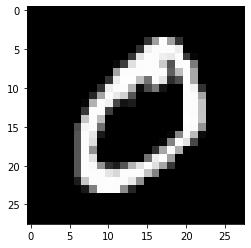

In [5]:
img = cv2.cvtColor(X_train[1],cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [6]:
X_train = X_train[0:5000]

In [7]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:,:,:,np.newaxis]

In [8]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [9]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=latent_dim))
generator.add(LeakyReLU(0.2))
generator.add(Reshape(( 7, 7,128)))
generator.add(UpSampling2D(size=(2,2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0

In [11]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                         input_shape=( 28, 28,1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)


In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [13]:
discriminator.trainable = False

In [14]:
ganInput = Input(shape=(latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)


In [15]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         275457    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 488,322
Trainable params: 275,457
Non-trainable params: 212,865
_________________________________________________________________


In [16]:
dLosses = []
gLosses = []

In [17]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [35]:
def plotGeneratedImages(epoch, examples=20, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples,latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i].reshape(28,28), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()

In [19]:
epochs = 5
batchSize = 128
batchCount = X_train.shape[0] / batchSize

  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [03:46<00:00,  5.80s/it]


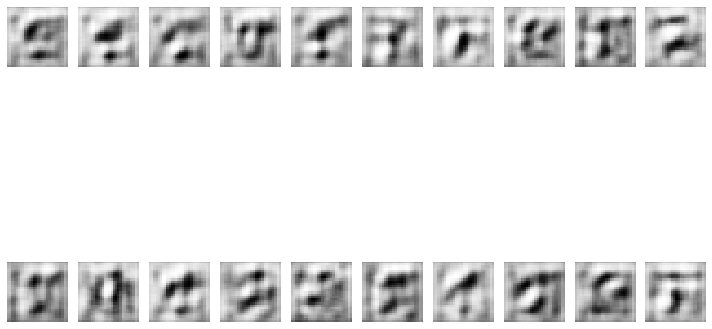

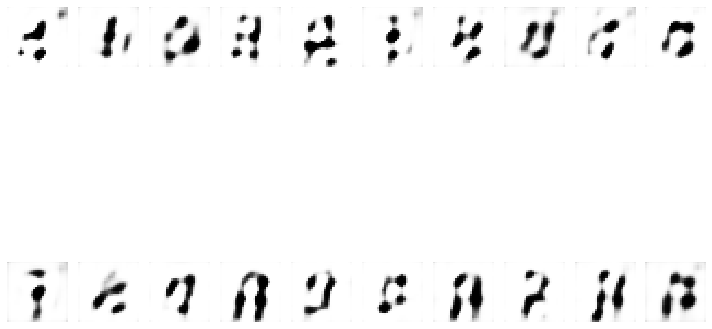

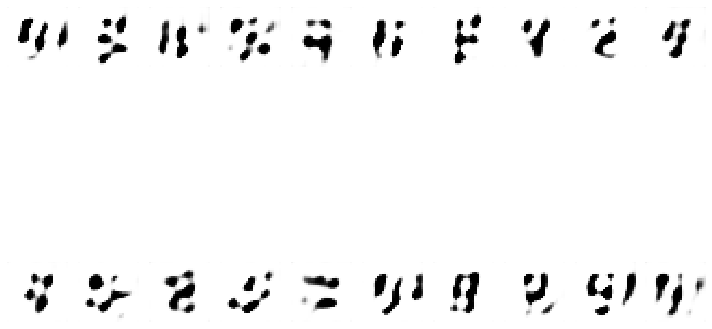

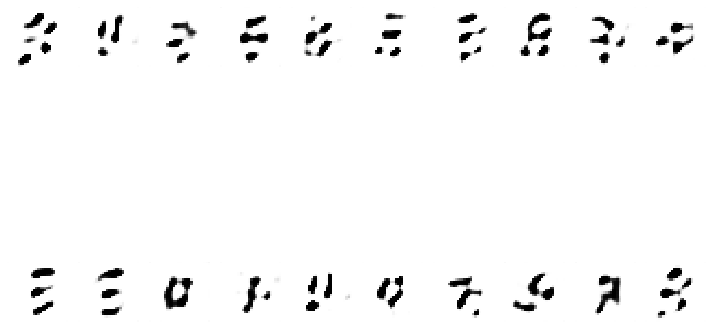

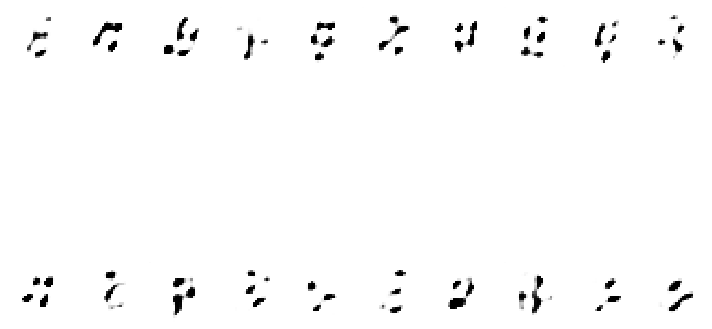

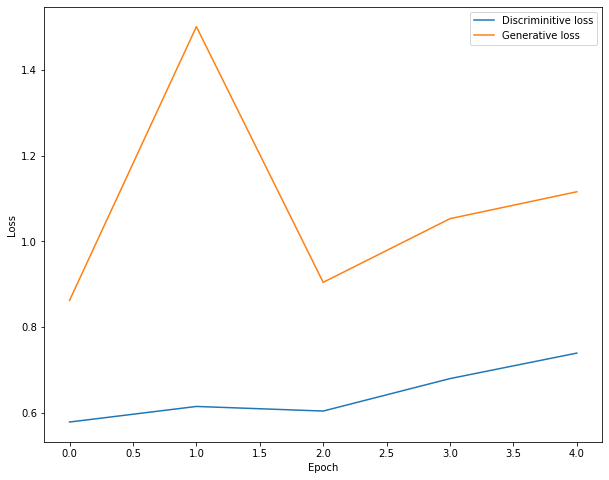

In [27]:
for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(int(batchCount))):
        noise = np.random.normal(0, 1, size=[batchSize,latent_dim])
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

        # Generate fake MNIST images
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])

        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize,latent_dim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)
 
    dLosses.append(dloss)
    gLosses.append(gloss)

    plotGeneratedImages(e)

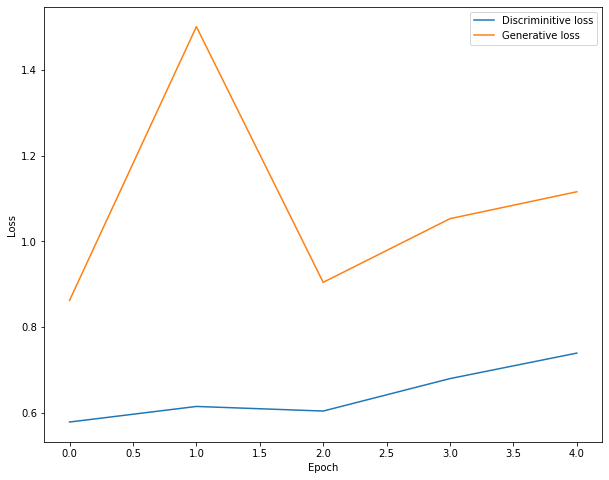

In [38]:
plotLoss(e)